In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import csv

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
from scipy import optimize
from pylab import *


In [45]:
path = '/srv/home/chenyu/DEbackup/2019/081919/S3/'

# Load HAADF file
file_HAADF = [image for image in os.listdir(path) if '_Preview' in image]
file_HAADF = file_HAADF[0]
with open(path +  file_HAADF) as csvfile:
    file=csv.reader(open(path+file_HAADF,'r'))
    n=[]
    for row in file:
        n.append(row)

HAADFarray = np.transpose(np.asarray(n))
HAADFarray = np.squeeze(HAADFarray)
HAADFarray = HAADFarray.astype(np.float)
HAADFarray = np.reshape(HAADFarray,(200,200))
# HAADFarray = HAADFarray[0:200,:]
HAADF_raw = HAADFarray # back up the raw array
HAADFarray = scipy.ndimage.gaussian_filter(HAADFarray,1)

# Refine positions of peaks
image_max = ndi.maximum_filter(HAADFarray, size=7, mode='constant')
coordinates = peak_local_max(HAADFarray, min_distance=4)

peaks_x_fit = []
peaks_y_fit = []

for i in range(coordinates.shape[0]):
    
    x = int(coordinates[i][1])
    y = int(coordinates[i][0])
    
    if x >=7 and y>=7:
        patch = HAADFarray[y-6:y+6,x-6:x+6]
        patch = patch - amin(patch)
        bg = 0

        # parameters are in the order of : background, height, cx, cy, wx, wy
        guess = (bg,patch[6,6]-bg,6, 6, 3, 3)
        bounds = ([0,0,0,0,1,1],[np.inf,np.inf,10,10,10,10])
        param = fitGaussianx2(patch, guess, bounds)

        peaks_x_fit.append(param[2]+x-6)
        peaks_y_fit.append(param[3]+y-6)
    


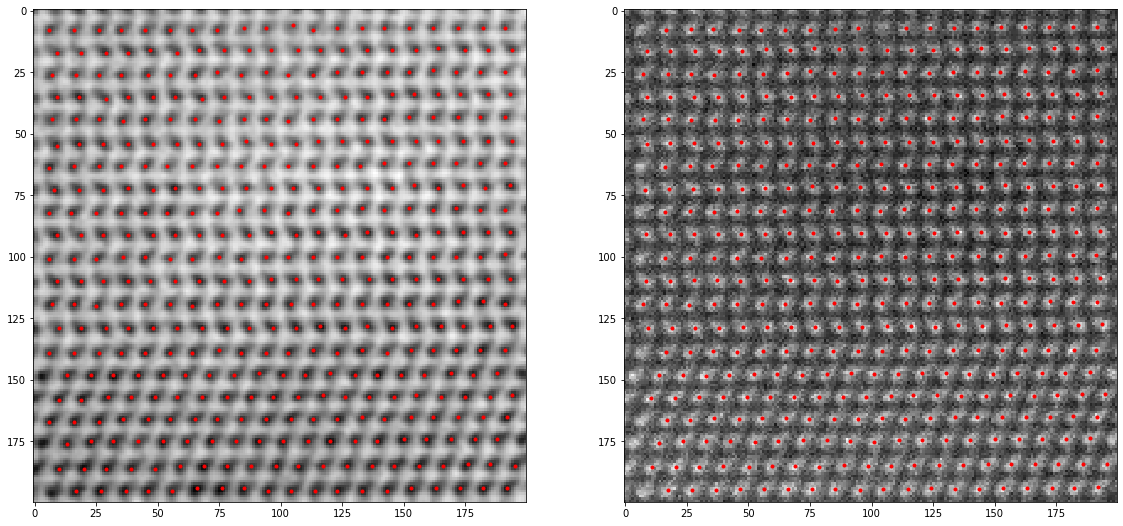

In [7]:

fig = plt.figure(figsize=(30,10))
fig.add_subplot(1,3,1)
plt.imshow(np.log(np.abs(HAADFarray)), cmap='gray')
# plt.axis('off')
plt.plot(coordinates[:,1], coordinates[:,0],'r.')

fig.add_subplot(1,3,2)
plt.imshow(HAADF_raw, cmap='gray')
# plt.axis('off')
plt.plot(peaks_x_fit, peaks_y_fit,'r.')

peaks_x_fit = coordinates[:,1]
peaks_y_fit = coordinates[:,0]


In [9]:
# Case of unit cell averaging on hexagonal phase
# Take average of two rows for the top 14 rows of peaks detected in coordinates matrix
list_copy = coordinates[coordinates[:,0].argsort()]
irow = 0
coordinates_uc = np.zeros((0,2))
while irow < 7:
    center = list_copy[0,0]
    print(list_copy.shape[0], center)
    index = find((list_copy[:,0] < center + 3 ) & (list_copy[:,0] > center - 3))
    row1 = list_copy[list_copy[index,1].argsort()]
#     print(index)
#     print(row1)
    list_copy = np.delete(list_copy, index, 0)
    index2 = find((list_copy[:,0] < center + 13 ) & (list_copy[:,0] > center + 8))
    row2 = list_copy[list_copy[index2,1].argsort()]
#     print(index2)
#     print(row2)
    coordinates_uc = vstack((coordinates_uc, (row1 + row2)/2))
    list_copy = np.delete(list_copy, index2, 0)
    irow = irow + 1
coordinates_uc = vstack((coordinates_uc,list_copy))

400 10
360 29
320 48
280 66
240 85
200 104
160 122


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  if __name__ == '__main__':
/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  


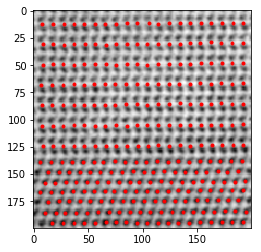

In [463]:
# Plot positions after unit cell V-cell on hexagonal phase
plt.imshow(np.log(np.abs(HAADFarray)), cmap='gray')
plt.plot(coordinates_uc[:,1], coordinates_uc[:,0],'r.')
peaks_x_fit = coordinates_uc[:,1]
peaks_y_fit = coordinates_uc[:,0]

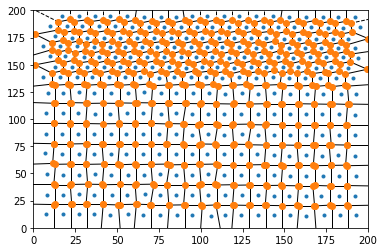

278

In [464]:
# Build Voroni cells
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(np.transpose(np.asarray([peaks_x_fit, peaks_y_fit])))
voronoi_plot_2d(vor)
plt.xlim([0,200])
plt.ylim([0,200])
plt.show()

len(vor.regions)

In [465]:
# Refine detected Voroni polygons, remove all the ones that contains border, i.e. vor.regions contain -1, empty cell, 
# cell with negative border, cell with border over pixel range

i = 0
while i != len(vor.regions):
    if -1 in vor.regions[i] or not vor.regions[i] or not all(vor.vertices[vor.regions[i]]>0) or not all(vor.vertices[vor.regions[i]]<369):
        del vor.regions[i]
    else:
        i = i+1
    

In [466]:
# Extract pixels within each Voroni cell
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Very inefficient way to loop over all Voroni polygons for each pixel
# Not sure how to quickly find all pixels within each polygon
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python
# Construct nx-by-ny px image with integers, each integer marks a voroni polygon

voroni_idx = np.zeros((200,200))

for irow in range(200):
    for icol in range(200):
        point = Point(icol,irow) # shapely.geomerty.Point is in the order of (x,y), thus (icol, irow)
        for ipolygon in range(len(vor.regions)):
            
            # vor.regions contains indices of points that form the polygon
            # vor.vertices contains coordinates of all points that are used to form Voroni polygons
            polygon = Polygon(vor.vertices[vor.regions[ipolygon]])
            
            if polygon.contains(point) is True:
                
                voroni_idx[irow,icol] = ipolygon+1
        

In [393]:
# Recalculate COM shift with symmetric ROI from reference point
# Real space scan grid size
num_rows = 200
num_cols = 200
# Reconstruct a BF image to check whether it matches HAADF
BF = np.zeros((num_rows,num_cols))
# Reciprocal space image size
rx = 200
ry = 200
kx = 512
ky = 512
kx = np.linspace(0,kx-1,kx)
ky = np.linspace(0,ky-1,ky)
weights_x, weights_y = np.meshgrid(kx,ky)
ref = np.load('/srv/home/chenyu/DEbackup/081919/BlankCOM.npy')
ExpName = 'S3'
COM_exp = np.zeros((num_rows,num_cols,2))
for irow in range(rx):
    for icol in range(ry):
        filenum = irow*num_cols+icol+1
        ref_x = ref[irow,icol,0]
        ref_y = ref[irow,icol,1]
        mask = create_circular_mask(512,512, center=[ref_x,ref_y], radius=min(ref_x,ref_y,511-ref_x,511-ref_y))
        frame = np.load(path+'npy/'+ExpName+'_'+format(filenum,'05')+'.npy')
        COM_exp[irow,icol,0] = np.average(weights_x,weights = frame*mask)
        COM_exp[irow,icol,1] = np.average(weights_y,weights = frame*mask)
        BF[irow,icol] = np.sum(frame*mask)

COM_exp = COM_exp - ref
np.save(path + 'COM_refine.npy',COM_exp)

KeyboardInterrupt: 

In [7]:
# np.save(path + 'Voroni_cell_map_uc.npy', voroni_idx)
# voroni_idx = np.load(path + 'Voroni_cell_map.npy')
COM_exp = np.load(path + 'COM_refine.npy')
voroni_idx = np.load(path + 'Voroni_cell_map.npy')
# COM_exp = np.load(path + 'COM_refine.npy')
rx = 200
ry = 200
# Extract momentum transfer and real space COM for each voroni polygon
# For this dataset, diffraction x-y is almost aligned with image edges, thus COM movement along x,y can be directly interpreted as polar

# Save information of each Voroni polgon inside a n-by-4 matrix, each row contains cx, cy, COMx, COMy
voroni_list = np.zeros((int(np.amax(voroni_idx)), 4))
voroni_x = np.zeros((rx,ry))
voroni_y = np.zeros((rx,ry))
rot = 90 # rotation in degrees, counter-clockwise as positive, following python setting
rot = math.radians(rot)
for i in range(int(np.amax(voroni_idx))):
    pixels = np.where(voroni_idx == i+1)
    voroni_list[i,0] = np.average(pixels[0])   # row index
    voroni_list[i,1] = np.average(pixels[1])   # col index
    voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]) # along x
    voroni_list[i,3] = np.average(COM_exp[pixels[0],pixels[1],1]) # along y
    
    voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]*cos(rot)-COM_exp[pixels[0],pixels[1],1]*sin(rot)) # along kx
#     voroni_list[i,2] = np.average(COM_exp[pixels[0],pixels[1],0]*cos(rot)-COM_exp[pixels[0],pixels[1],1]*sin(rot)) - 0.15/0.147/0.4 # along kx

    voroni_list[i,3] = np.average(COM_exp[pixels[0],pixels[1],1]*cos(rot)+COM_exp[pixels[0],pixels[1],0]*sin(rot)) # along ky
    
#     voroni_list[i,2] = np.average(ref[pixels[0],pixels[1],0]-np.average(ref[:,:,0]))  # row, col, kx
#     voroni_list[i,3] = np.average(ref[pixels[0],pixels[1],1]-np.average(ref[:,:,1]))  # row, col, ky
    
    voroni_x[pixels] = voroni_list[i,2] 
    voroni_y[pixels] = voroni_list[i,3]

(2.1192381332269647,
 203.61773833266852,
 -53.29985588972431,
 143.65486842105264)

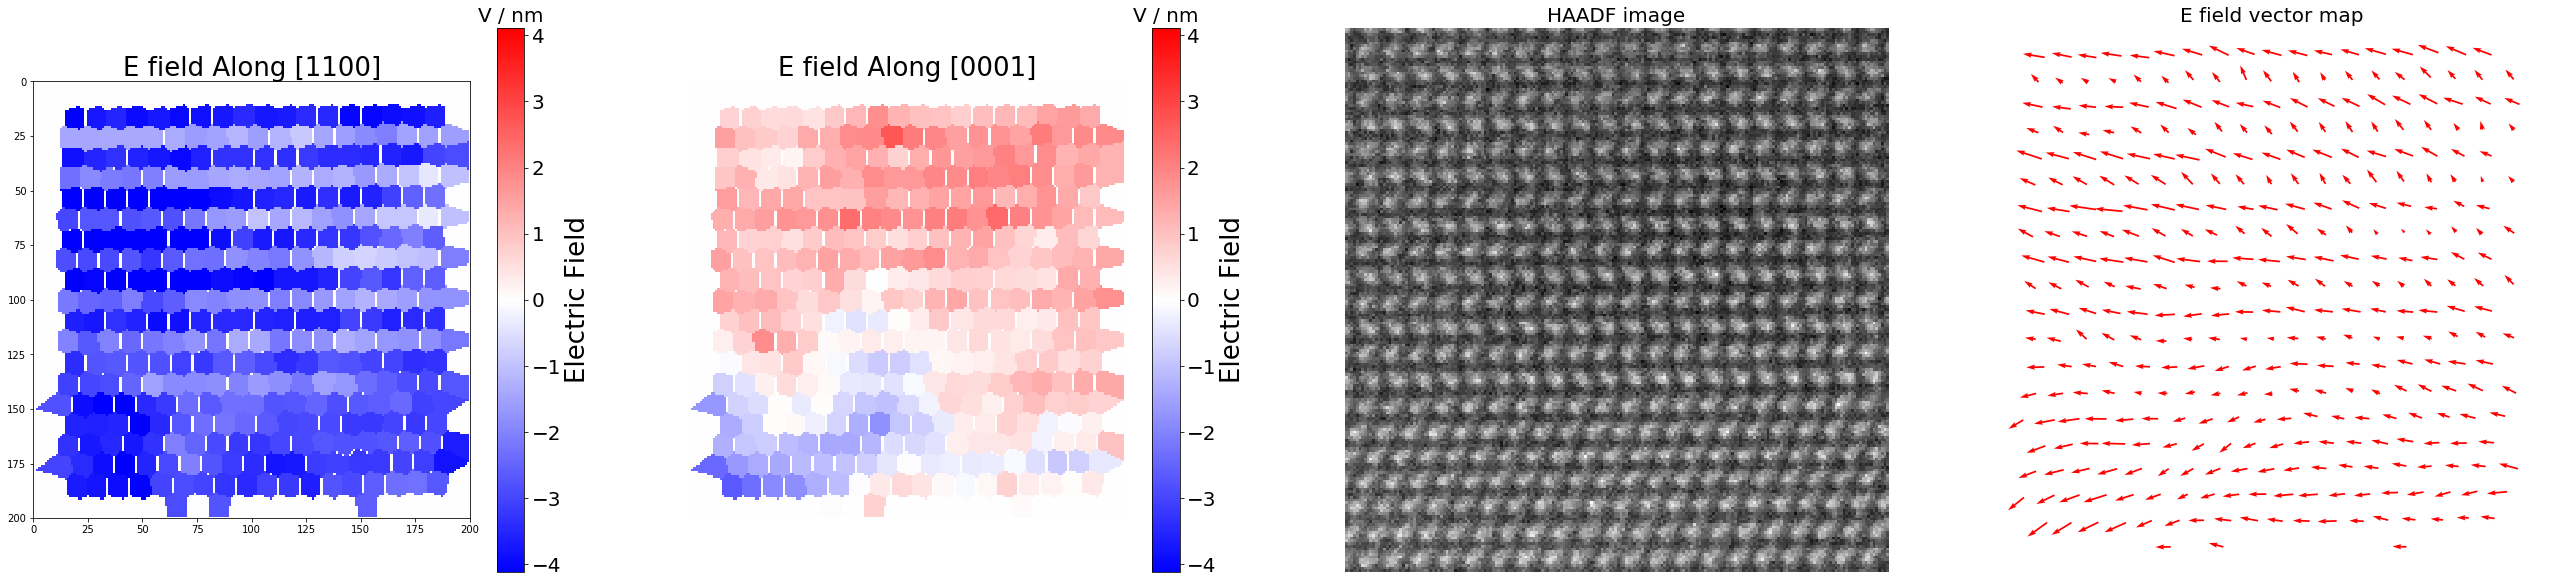

In [28]:
fig = plt.figure(figsize=(45,10))
fig.add_subplot(1,4,1)
# need minus sign to plot electric field instead of momentum change
plt.imshow(-voroni_x  * 0.147 * 0.4* 13.70,cmap=plt.cm.bwr,\
           clim=[-0.3* 13.70,0.3* 13.70])
# plt.clim([-3* 0.147 * 0.4,3* 0.147 * 0.4])
plt.title('E field Along [1100]',fontsize=26)
plt.xlim([0,200])
plt.ylim([200,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('V / nm', fontsize = 20)
cbar.ax.set_ylabel('Electric Field',fontsize = 26)
# plt.axis('off')

fig.add_subplot(1,4,2)
plt.imshow(-voroni_y *0.147 * 0.4* 13.70,cmap=plt.cm.bwr,clim = [-0.3* 13.70, 0.3* 13.70])
plt.title('E field Along [0001]',fontsize=26)
# plt.clim([-3* 0.147 * 0.4,3* 0.147 * 0.4])
plt.xlim([0,200])
plt.ylim([200,0])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('V / nm', fontsize = 20)
cbar.ax.set_ylabel('Electric Field',fontsize = 26)
plt.axis('off')

fig.add_subplot(1,4,3)
plt.imshow(HAADF_raw,cmap='gray',origin='upper')
plt.title('HAADF image',fontsize=20)
plt.axis('off')
# plt.scatter(peaks_x_fit, peaks_y_fit)
# plt.imshow(np.flipud(np.transpose(HAADFarray)),cmap='gray')
# plt.scatter(np.asarray(peaks_y_fit),149-np.asarray(peaks_x_fit))

fig.add_subplot(1,4,4)
plt.quiver(voroni_list[:,1], 150-voroni_list[:,0], -voroni_list[:,2], -voroni_list[:,3],color='r')
plt.title('E field vector map', fontsize=20)
plt.axis('off')

## Extract PACBED pattern on different layer
Check whether there are any visible difference between the PACBED on different layer of the strips.

In [74]:
# Load the resultsin voroni_list to 

list_copy = voroni_list
PACBED_negative = np.zeros((512,512))
PACBED_positive = np.zeros((512,512))
negative_count = 0
positive_count = 0

while list_copy.shape[0] != 0:
    center = list_copy[0,0]
    if center < 125:       # only use the hexagonal part with row index < 125
        index = (list_copy[:,0] < center + 3 ) & (list_copy[:,0] > center - 3)
        index = [i for i, val in enumerate(index) if val] 
        print(index)
        row_polar = np.mean(list_copy[index,2])    # first column, mean buckling along x or [1100]
        
        if row_polar < 3:  # average COM change <3, attribute to negative PACBED
            print(row_polar)
            for j in range(len(index)):
                pixels = np.where(voroni_idx == index[j])
                for i in range(len(pixels[0])):
                    filenum = pixels[0][i]*ry+pixels[1][i]+1
                    frame = np.load(path+'npy/'+'S3_'+format(filenum,'05')+'.npy')
                    PACBED_negative = PACBED_negative + frame
                    negative_count = negative_count + 1
                
        else:              # else, attribute to positive PACBED
            print(row_polar)
            for j in range(len(index)):
                pixels = np.where(voroni_idx == index[j])
                for i in range(len(pixels[0])):
                    filenum = pixels[0][i]*ry+pixels[1][i]+1
                    frame = np.load(path+'npy/'+'S3_'+format(filenum,'05')+'.npy')
                    PACBED_positive = PACBED_positive + frame
                    positive_count = positive_count + 1
                
        list_copy = np.delete(list_copy, index, 0)
        
    else: # if row index > 125, skip this row and remove the entree in the list
        list_copy = np.delete(list_copy, 0, 0)

PACBED_positive = PACBED_positive / positive_count
PACBED_negative = PACBED_negative / negative_count

[0, 6, 35, 36, 196, 200, 202, 203, 217, 220, 225, 304, 320, 322, 324, 336, 338, 342]
4.615210557784916
[0, 54, 72, 74, 76, 99, 109, 110, 133, 136, 137, 139, 140, 151, 152, 156, 160, 166, 168]
2.412537379602675
[0, 21, 30, 51, 70, 71, 75, 95, 125, 126, 127, 139, 141, 147, 148, 154, 157, 205]
4.352914814244892
[0, 28, 32, 33, 38, 42, 43, 44, 111, 112, 179, 180, 182, 219, 220, 223, 224, 226]
4.669022294259003
[0, 34, 35, 95, 96, 101, 102, 105, 106, 160, 169, 170, 206, 207, 208, 212, 213, 228, 231]
1.8155923731264947
[0, 1, 32, 33, 90, 91, 94, 95, 96, 97, 150, 151, 194, 196, 200, 201, 208, 210, 211]
4.270966234993181
[0, 25, 26, 71, 74, 75, 78, 132, 134, 135, 141, 146, 191, 199, 215, 216, 221, 228, 229]
2.201252099063885
[0, 7, 35, 38, 40, 45, 50, 51, 83, 84, 85, 87, 89, 97, 98, 102, 103, 123, 124]
2.356110463906452
[0, 2, 27, 47, 69, 70, 83, 84, 87, 88, 95, 97, 138, 143, 146, 163, 164, 173, 174]
2.426041228561908
[0, 7, 25, 37, 38, 43, 60, 61, 62, 63, 64, 77, 78, 85, 124, 125, 130, 131]
4

(-0.5, 511.5, 511.5, -0.5)

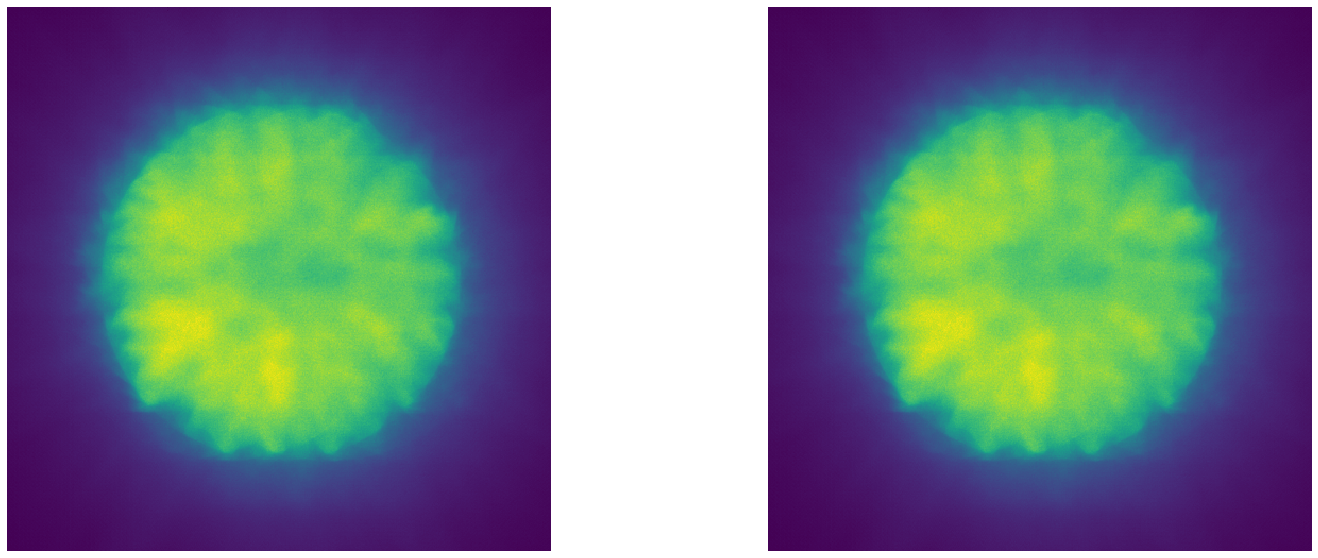

In [77]:
fig = plt.figure(figsize=(25,10))
fig.add_subplot(1,2,1)
plt.imshow(PACBED_negative)
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(PACBED_positive)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

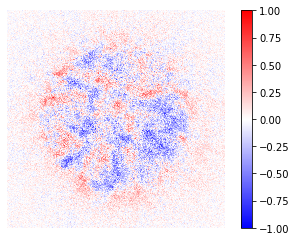

In [78]:
plt.imshow(PACBED_positive - PACBED_negative,clim=[-1,1],cmap='bwr')
plt.colorbar()
plt.axis('off')

### Conclusion:
Current comparison between the negative and positive PACBED seems to suggest no clear difference. No clear difference between the position of two zero disks. Also no clear difference between the intensity distribution.
The PACBED patterns used for direct comparison are not corrected for the beam drift, this might be a problem.

## Calculate averaged polarization for each layer of atom

In [76]:
# Plot polarization map with unit cell averaging on hexagonal phase
# For first 12 rows of V-cells in hexagonal phase, average over every two layers

list_copy = voroni_list[voroni_list[:,0].argsort()]
row_polar = np.zeros((40,4))
irow = 0
while list_copy.shape[0] != 0:
    center = list_copy[0,0]
#     print(list_copy.shape[0], center)
    index = find((list_copy[:,0] < center + 3 ) & (list_copy[:,0] > center - 3))
#     print(index)
    row_polar[irow,0] = np.mean(list_copy[index,2])    # first column, mean buckling along x/[1100]
    row_polar[irow,1] = np.std(list_copy[index,2])/sqrt(len(index))    # second column, standard deviation of mean along x/[1100]
    row_polar[irow,2] = np.mean(list_copy[index,3])    # third column, mean buckling along y/[0001]
    row_polar[irow,3] = np.std(list_copy[index,3])/sqrt(len(index))    # fourth column, standard deviation of mean along y/[0001]
    list_copy = np.delete(list_copy, index, 0)
    irow = irow + 1
# print(row_buckling.shape)
row_polar = row_polar[~np.all(row_polar == 0, axis=1)]

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  # Remove the CWD from sys.path while we load stuff.


In [77]:
list_copy = voroni_list[voroni_list[:,0].argsort()]
row_polar = np.zeros((40,4))
irow = 0
while list_copy.shape[0] != 0:
    center = list_copy[0,0]
#     print(list_copy.shape[0], center)
    index = find((list_copy[:,0] < center + 3 ) & (list_copy[:,0] > center - 3))
#     print(index)
    row_polar[irow,0] = np.mean(list_copy[index,2])    # first column, mean buckling along x/[1100]
    row_polar[irow,1] = np.std(list_copy[index,2])/sqrt(len(index))    # second column, standard deviation of mean along x/[1100]
    row_polar[irow,2] = np.mean(list_copy[index,3])    # third column, mean buckling along y/[0001]
    row_polar[irow,3] = np.std(list_copy[index,3])/sqrt(len(index))    # fourth column, standard deviation of mean along y/[0001]
    list_copy = np.delete(list_copy, index, 0)
    irow = irow + 1
# print(row_buckling.shape)
row_polar = row_polar[~np.all(row_polar == 0, axis=1)]

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The find function was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  import sys


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


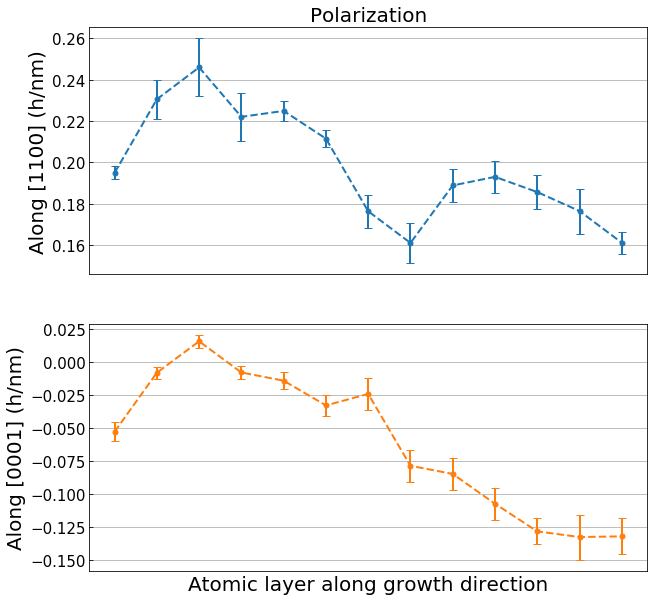

In [78]:
fig = plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title('Polarization', fontsize=20)
plt.errorbar(np.linspace(1,row_polar.shape[0],row_polar.shape[0]),row_polar[::-1,0]* 0.147 * 0.4,\
             yerr=row_polar[:,1]* 0.147 * 0.4,fmt='--o',linewidth=2, ms=5, capsize=4, elinewidth=2)
# plt.xlabel('Atomic layer index',fontsize=20)
plt.ylabel('Along [1100] (h/nm)',fontsize=20)
plt.tick_params(labelsize=15,direction='in')
plt.grid('on')
plt.xticks([])

plt.subplot(212)
plt.errorbar(np.linspace(1,row_polar.shape[0],row_polar.shape[0]),row_polar[::-1,2]* 0.147 * 0.4,\
             yerr=row_polar[:,3]* 0.147 * 0.4,fmt='--o',linewidth=2, c='#ff7f0e', ms=5, capsize=4, elinewidth=2)
plt.xticks([])
plt.xlabel('Atomic layer along growth direction',fontsize=20)
plt.ylabel('Along [0001] (h/nm)',fontsize=20)
plt.tick_params(labelsize=15,direction='in')
plt.grid('on')


/srv/home/chenyu/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


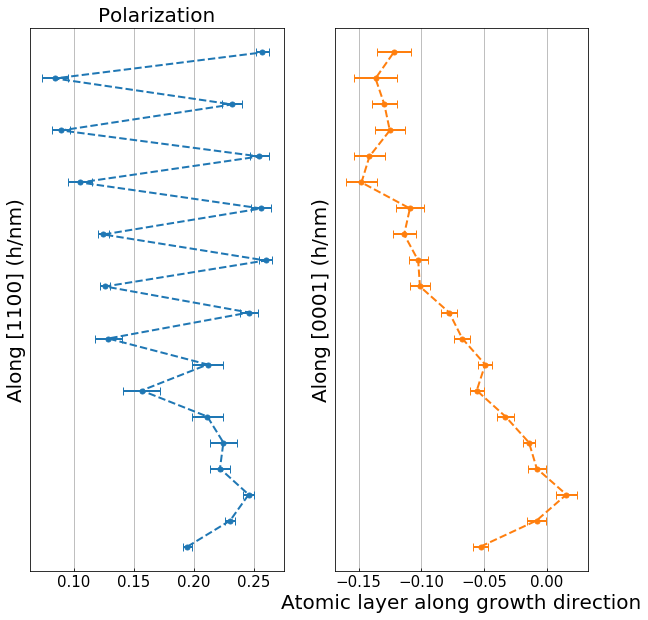

In [27]:
fig = plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Polarization', fontsize=20)
plt.errorbar(row_polar[::-1,0]* 0.147 * 0.4,np.linspace(1,row_polar.shape[0],row_polar.shape[0]),\
             xerr=row_polar[:,1]* 0.147 * 0.4,fmt='--o',linewidth=2, ms=5, capsize=4, elinewidth=2)
# plt.xlabel('Atomic layer index',fontsize=20)
plt.ylabel('Along [1100] (h/nm)',fontsize=20)
plt.tick_params(labelsize=15,direction='in')
plt.grid('on')
plt.yticks([])

plt.subplot(122)
plt.errorbar(row_polar[::-1,2]* 0.147 * 0.4, np.linspace(1,row_polar.shape[0],row_polar.shape[0]),\
             xerr=row_polar[:,3]* 0.147 * 0.4,fmt='--o',linewidth=2, c='#ff7f0e', ms=5, capsize=4, elinewidth=2)
plt.yticks([])
plt.xlabel('Atomic layer along growth direction',fontsize=20)
plt.ylabel('Along [0001] (h/nm)',fontsize=20)
plt.tick_params(labelsize=15,direction='in')
plt.grid('on')


In [79]:
PACBED = np.zeros((512,512))
for irow in range(100):
    for icol in range(ry):
        filenum = irow*ry+icol+1
        frame = np.load(path+'npy/'+'S3_'+format(filenum,'05')+'.npy')
        PACBED = PACBED + frame

(-0.5, 511.5, 511.5, -0.5)

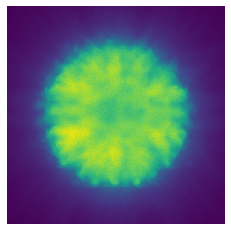

In [80]:
plt.imshow(PACBED)
plt.axis('off')

# Aux functions

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [4]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

In [5]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [6]:
import struct
def loadMRCfile(filepath):
    with open(filepath, mode='rb') as file: # b is important -> binary
        file.seek(0)
        read_bytes = file.read(8)
        frame_width = struct.unpack('<i',read_bytes[0:4])
        frame_width = frame_width[0]
        frame_height = struct.unpack('<i',read_bytes[4:8])
        frame_height = frame_height[0]
        image = np.zeros((frame_height,frame_width))
        file.seek(256*4)
        dataset = file.read(frame_width*frame_height*4)
        for irow in range(frame_height):
            for icol in range(frame_width):
                pixel = struct.unpack('<f',dataset[(irow*frame_width+icol)*4:(irow*frame_width+icol+1)*4])[0]
                image[irow,icol] = pixel
        return image

In [363]:
temp = loadMRCfile('/srv/home/chenyu/DEbackup/081919/DEcapture_SampleOverview.mrc')

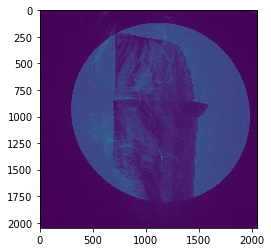

In [365]:
plt.imshow(temp)